In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters

In [62]:
h = 0.01
k = 0.01
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cp = 0.154
lambd_nb = 40
mi_n = 0.2
lambd_bn = 0.1
X_nb = 0.0001
y_n = 0.1
C_nmax = 0.55

x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))
size_y = int(((y_dom[1] - y_dom[0]) / (h)))
size_tt = int(((t_dom[1] - t_dom[0]) / (k)))

x = np.linspace((x_dom[1], x_dom[0]), size_x)
y = np.linspace((y_dom[1], y_dom[0]), size_y)
t = np.linspace((t_dom[1], t_dom[0]), size_tt)

# Model definition

In [63]:
class PINN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = torch.nn.Sequential(
            nn.Linear(3, 16),
            nn.Sigmoid(),
            nn.Linear(16, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [64]:
def gerenate_training(num_points):
    x = torch.rand(num_points, 1, requires_grad=True)
    y = torch.rand(num_points, 1, requires_grad=True)
    t = torch.rand(num_points, 1, requires_grad=True)

    return x, y, t

In [65]:
def initial_condition(x, y):

    Cp = torch.zeros_like(x)
    Cl = torch.zeros_like(x)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.58)) and ((yy >= 0.5) and (yy <= 0.58)):
            Cp[i] = 0.2

    return torch.cat([Cl, Cp], dim=1)

In [66]:
def gerenate_boundary_training_data(num_points, up_limit=1, direction="x"):

    x_boundary = torch.tensor([0, up_limit]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points, requires_grad=True)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        n_boundary = torch.tensor([0, -1, 0, 1])
        n_boundary = n_boundary.repeat(num_points // 2)

    else:
        n_boundary = torch.tensor([-1, 0, 1, 0])
        n_boundary = n_boundary.repeat(num_points // 2)

    t = torch.rand(num_points, 1, requires_grad=True)

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1), t, n_boundary.view(-1, 2)

In [67]:
x_b, y_b, t_b, n = gerenate_boundary_training_data(10)
model = PINN()

In [68]:
model = PINN()

In [69]:
def boundary_condition(x_b, y_b, t_b, n, model, custom_value=0):
    input_data = torch.cat([x_b, y_b, t_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    if n[0][0].item() == 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            (Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])
        ) - custom_value
        Cp_boundary = Db * dCp_dx[0] - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            (Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])
        ) - custom_value
        Cp_boundary = Db * dCp_dy[0] - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [70]:
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cp * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (C_nmax - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt
    
    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [97]:
def train_PINN(model, num_iterations, num_points):
    adam = optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = optim.LBFGS(
    #         model.parameters(),
    #         lr=1.0,
    #         max_iter=50000,
    #         max_eval=50000,
    #         history_size=50,
    #         tolerance_grad=1e-7,
    #         tolerance_change=1.0 * np.finfo(float).eps,
    #         line_search_fn="strong_wolfe",
    #     )

    adam.zero_grad()
    # optimizer.zero_grad()

    C_initial_loss_it = []
    C_boundary_loss_it = []
    C_loss_it = []

    for it in range(num_iterations):

        x, y, t = gerenate_training(num_points)

        t_initial = torch.zeros_like(t)
        C_initial = initial_condition(x, y)

        x_b_x, y_b_x, x_b_y, y_b_y, t_b, n_x, n_y = gerenate_boundary_training_data(
            num_points
        )

        C_boundary = boundary_condition(x_b, y_b, t_b, n, model)

        C = pde(x, y, t, model)

        C_initial_pred = model(torch.cat([x, y, t_initial], dim=1))

        C_initial_loss = nn.MSELoss()(C_initial, C_initial_pred)

        C_boundary_loss = nn.MSELoss()(C_boundary, torch.zeros_like(C_boundary))

        C_loss = nn.MSELoss()(C, torch.zeros_like(C))

        loss = C_initial_loss + C_boundary_loss + C_loss

        loss.backward()

        C_boundary_loss_it.append(C_boundary_loss.item())
        C_loss_it.append(C_loss.item())
        C_initial_loss_it.append(C_initial_loss.item())

        adam.step()

    # optimizer.step(loss)

    return C_boundary_loss_it, C_initial_loss_it, C_loss_it

In [98]:
model = PINN()

n_iterations = 50

C_boundary_loss_it, C_initial_loss_it, C_loss_it = train_PINN(
    model, n_iterations, size_x
)

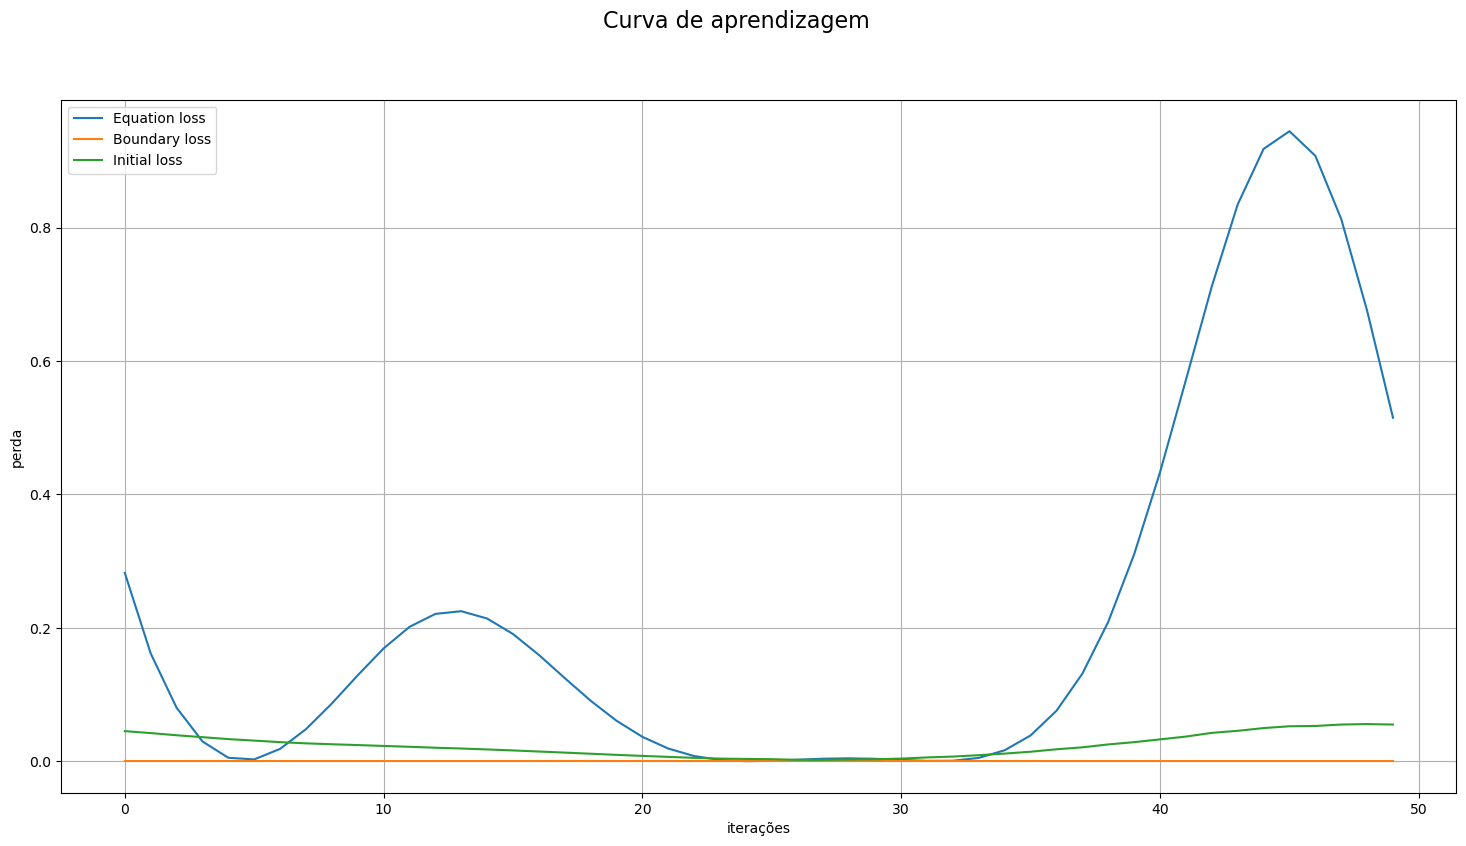

In [99]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_loss_it)),C_loss_it,label="Equation loss")
ax.plot(range(len(C_boundary_loss_it)),C_boundary_loss_it,label="Boundary loss")
ax.plot(range(len(C_initial_loss_it)),C_initial_loss_it,label="Initial loss")

ax.grid()
ax.legend()


plt.show()

In [74]:
from time import time 

time()

1712781526.3150015